# Causal Python - PyCon2021 IL
# Dr. Hanan Shteingart

## Sex Bias in Graduate Admissions: Data From Berkeley

Simpson's Paradox (Confounder Bias) Effect Estimation in 4 Ways:
1. Naive
2. Standarization
3. Regression
4. IPTW

Inspired by a Science paper:
P.J. Bickel, E.A. Hammel and J.W. O'Connell (1975). "Sex Bias in Graduate Admissions: Data From Berkeley" (PDF). Science. 187 (4175): 398–404. doi:10.1126/science.187.4175.398. PMID 17835295.

In [253]:
import pandas as pd
import numpy as np
from io import StringIO

In [190]:
dataset = """Department,Male-Admitted,Male-Denied,Female-Admitted,Female-Denied
A,512,313,89,19
B,313,207,17,8
C,101,205,202,391
D,138,279,131,244
E,40,138,94,299
F,22,351,24,317"""
# from https://raw.githubusercontent.com/hupili/python-for-data-and-media-communication-gitbook/master/assets/1973-UC-Berkeley-Admission-Data-Synthesis-Data.csv
df = pd.read_csv(StringIO(dataset))
df

,Department,Male-Admitted,Male-Denied,Female-Admitted,Female-Denied
0,A,512,313,89,19
1,B,313,207,17,8
2,C,101,205,202,391
3,D,138,279,131,244
4,E,40,138,94,299
5,F,22,351,24,317


In [195]:
def melt_and_duplicate(df):
    """convert the summary stats to raw data where every row is a student"""
    df_melt = df.melt(id_vars='Department',var_name='group', value_name='count')
    df_melt['male'] = df_melt['group'].str.contains('Male')
    df_melt['admitted'] = df_melt['group'].str.contains('Admitted')
    df_list = []
    for i in range(len(df_melt)):
        df_list.append(pd.concat([df_melt.iloc[[i]]] * df_melt.iloc[i]['count'], axis=0))
    df_raw = pd.concat(df_list, axis=0)
    df_raw = df_raw.drop(['group', 'count'], axis=1)
    return df_raw
df_raw = melt_and_duplicate(df)
df_raw

,Department,male,admitted
0,A,True,True
0,A,True,True
0,A,True,True
0,A,True,True
0,A,True,True
...,...,...,...
23,F,False,False
23,F,False,False
23,F,False,False
23,F,False,False


## Native Approach 

0.1263928553964791


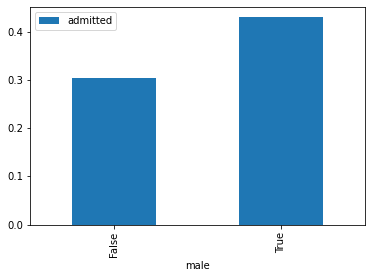

In [249]:
naive_est = df_raw.groupby('male')['admitted'].mean()
naive_est.plot(kind='bar', legend=True)
naive_ate = naive_effect.diff()[1]
print(naive_ate)

## Wrong conclusion: Bias in admission to favour males over females

## Stantarization 

In [152]:
p_x = df_raw.Department.value_counts(normalize=True)
p_x.to_frame()

,Department
A,0.209475
C,0.201841
D,0.177818
F,0.160305
E,0.128199
B,0.122362


In [153]:
p_y_x = df_raw.groupby(['Department','male'])['admitted'].mean()
p_y_x = p_y_x.reset_index(level=1)
p_y_x

,male,admitted
Department,,
A,False,0.824074
A,True,0.620606
B,False,0.680000
B,True,0.601923
C,False,0.340641
C,True,0.330065
D,False,0.349333
D,True,0.330935
E,False,0.239186


In [157]:
p_y_x['weighted'] = p_y_x['admitted'] * p_x

In [247]:
stratified_ate = p_y_x.groupby('male').weighted.sum().diff()[1]
print(stratified_ate)

-0.06126318937738062


In [165]:
stratified_effect.diff()

male
False         NaN
True    -0.061263
Name: weighted, dtype: float64

## Regression Adjustment

In [171]:
from statsmodels.regression.linear_model import OLS

In [198]:
import statsmodels.formula.api as smf

In [243]:
df_raw['y'] = df_raw.admitted.astype('float')
reg_model = smf.ols(formula = 'y ~ male + C(Department)', data=df_raw.reset_index()).fit()
reg_ate = reg_model.params['male[T.True]']
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     153.9
Date:                Mon, 26 Apr 2021   Prob (F-statistic):          4.25e-178
Time:                        18:38:11   Log-Likelihood:                -2675.4
No. Observations:                4454   AIC:                             5365.
Df Residuals:                    4447   BIC:                             5410.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6775      0.020     34.086      0.000       0.639       0.716
male[T.True]          -0.0377      0.015     -2.442      0.015      -0.068      -0.007
C(Department)[T.B]    -0.0360      0.024     -1.512      0.131      -0.083       0.011
C(Department)[T.C]    -0.3276      0.022    -14.707      0.000      -0.371      -0.284
C(Department)[T.D]    -0.3180      0.022    -14.431      0.000      -0.361      -0.275
C(Department)[T.E]    -0.4310      0.025    -17.195      0.000      -0.480      -0.382
C(Department)[T.F]    -0.5934      0.023    -26.193      0.000      -0.638      -0.549
==============================================================================
Omnibus:                     2839.241   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.503
Skew:                           0.328   Prob(JB):                     1.71e-72
Kurtosis:                       1.838   Cond. No.                         8.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## IPTW

In [206]:
df_raw['male_float'] = df_raw['male'].astype('float')
propensity_model = smf.ols(formula = 'male_float ~ C(Department)', data = df_raw.reset_index()).fit()

In [214]:
p = propensity_model.get_prediction().predicted_mean

In [244]:
iptw_ate = (df_raw['admitted']*(df_raw['male'] -p)/(p*(1-p))).mean()

## Summary

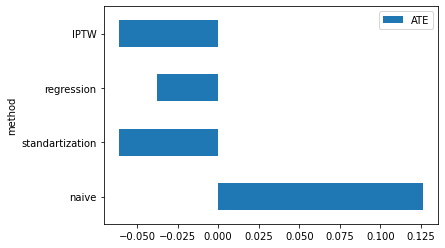

In [255]:
pd.DataFrame({'method':['naive','standartization','regression','IPTW'], 
              'ATE':[naive_ate, stratified_ate, reg_ate,iptw_ate]}).set_index('method').plot(kind='barh');